## The steady Navir-Stokes equation (Cylinder)
#### (1.1) The governing equation 
The governing PDE is
\begin{equation}
\begin{split}
 {\bf u}_t+ ({\bf u}\cdot\nabla){\bf u} &= - \frac{1}{\rho}\nabla p+\frac{\mu}{\rho}\nabla^2{\bf u}  + {\bf f}, \quad \text{in}\ \Omega \\
   \nabla\cdot {\bf u} &= 0,\quad \text{in}\ \Omega
\end{split}
\end{equation}
where $p(N/m^2)$ is the pressure, ${\bf u} (m/s)$ is the velocity vector, ${\bf f}$ is the applied body force, $\mu$ is the dynamic viscosity and $\rho$ is the density of fluid.
A typical set of boundary conditions on the boundary $\partial\Omega = \Gamma_D\cup \Gamma_N$ can be:
\begin{equation}
\begin{split}
 {\bf u} = {\bf u}_0, \quad \text{on}\ \Gamma_D \\
(\nabla\cdot{\bf u}+p)\cdot\vec{n} = g\quad \text{on}\ \Gamma_N
\end{split}
\end{equation}
#### (1.2) The continuum and constitutive formulations
\begin{equation}
\begin{split}
 {\bf u}_t+ ({\bf u}\cdot\nabla){\bf u} &= \frac{1}{\rho}\nabla\cdot {\bf \sigma} + {\bf f}, \quad \text{in}\ \Omega \\
   \nabla\cdot {\bf u} &= 0,\quad \text{in}\ \Omega 
\end{split}
\end{equation}
where 
\begin{equation}
{\bf \sigma} = -p{\bf I} + \mu(\nabla{\bf u}+\nabla{\bf u}^T) 
\end{equation}
is the Cauchy stress tensor, and $p=-tr({\bf \sigma})/2$.
#### (1.3) The weak form
\begin{equation}
\begin{split}
\int {\bf u}_t {\bf \psi}~dx + \int ({\bf u}\cdot\nabla){\bf u}{\bf \psi}~dx = -\frac{1}{\rho}\int {\bf \sigma} \cdot\nabla^T\psi ~dx + \int {\bf f}\psi~dx
\end{split}
\end{equation}
where 
\begin{equation}
{\bf \sigma} = -p{\bf I} + \mu(\nabla{\bf u}+\nabla{\bf u}^T), 
\end{equation}
and $p=-tr({\bf \sigma})/2$.
#### (1.4) The problem
The domain is given in the following figure and the initial/boundary conditions are given as:
- **In flow:** ${\bf u}=(U\frac{4(0.41-y)y}{0.41^2}, 0)$
- **Out flow:** $p=0$
- **non-slip wall:** ${\bf u}={\bf 0}$
- **Cylinder:** ${\bf u=0}$
  
For the parameters in the equation, we set  $\rho=0.02(kg/m\cdot s)$ and $\mu=1kg/m^3$.

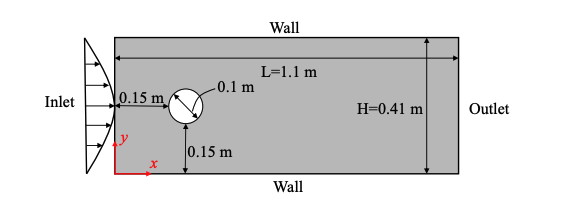

### (1) The PINN

dict_keys(['__header__', '__version__', '__globals__', 'x', 'u', 'v', 'p'])


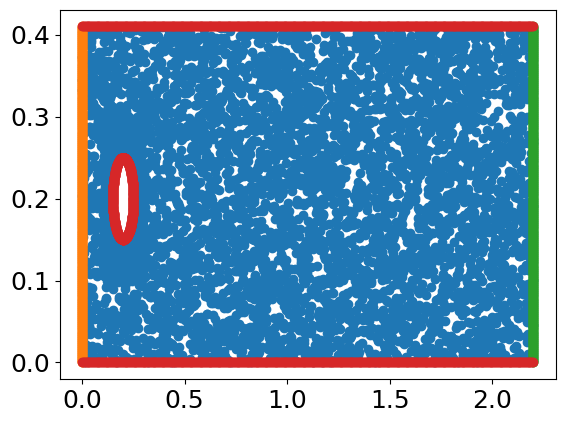

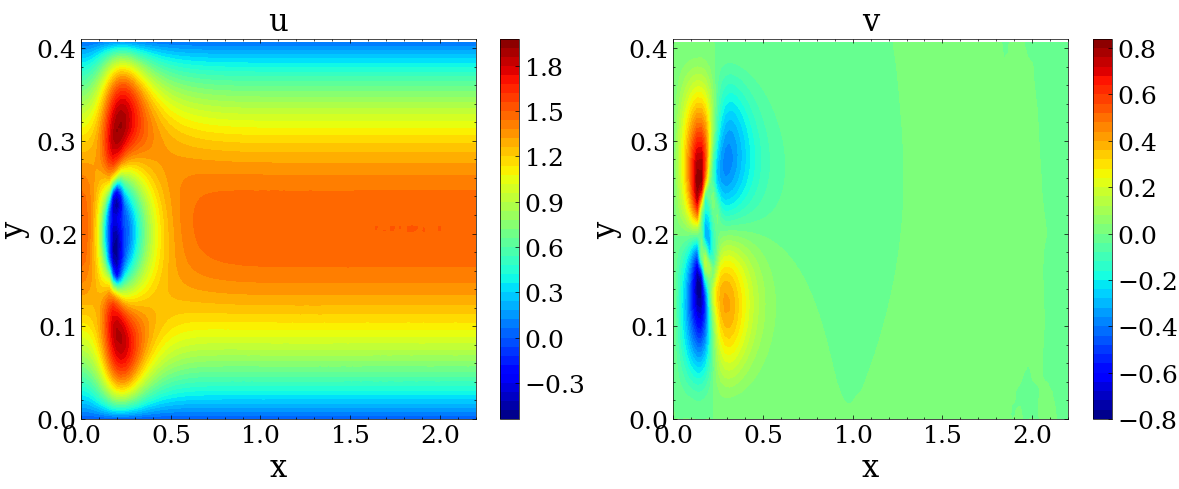

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch
import scipy.io
from Utils.GenPoints import Point2D
from Utils.PlotFigure import Plot
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 123
device = 'cuda:0'
dtype = torch.float32
setup_seed(random_seed)
problem_name = 'NSteady_cylinder'
####################################
# Load data
####################################
try:
    data = h5py.File('../../Problems/NS_steady/truth_cylinder.mat', 'r')
except:
    data = scipy.io.loadmat('../../Problems/NS_steady/truth_cylinder.mat')
print(data.keys())
u_test, v_test, x_test = np.array(data['u']), np.array(data['v']), np.array(data['x'])
u_test = torch.tensor(u_test.reshape(-1,1), dtype=dtype)
v_test = torch.tensor(v_test.reshape(-1,1), dtype=dtype)
x_test = torch.tensor(x_test, dtype=dtype)
######################################
# Setups of the problem 
######################################
N_in, N_refine, N_bd_each_edge = 5000, 1000, 500
#
pointGen = Point2D(x_lb=[0., 0.], x_ub=[2.2, 0.41], dataType=dtype, random_seed=random_seed)
refineGen = Point2D(x_lb=[0.1, 0.1], x_ub=[0.3, 0.3], dataType=dtype, random_seed=random_seed)
# The inner points
x_in = pointGen.inner_point(num_sample_or_mesh=N_in, method='hypercube')
x_in_refine = refineGen.inner_point(num_sample_or_mesh=N_refine, method='hypercube')
x_in_train = torch.cat((x_in, x_in_refine), axis=0)
index = torch.where(torch.linalg.norm(x_in_train-torch.tensor([0.2,0.2]), axis=1, keepdims=True) >0.05)[0]
x_in_train = x_in_train[index,:]
# The boundary points
x_bd_train = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='mesh')
#
x_lt = x_bd_train[0:N_bd_each_edge]
x_rt = x_bd_train[N_bd_each_edge:2*N_bd_each_edge]
x_bt = x_bd_train[2*N_bd_each_edge:3*N_bd_each_edge]
x_up = x_bd_train[3*N_bd_each_edge:]
x_cld = pointGen.boundary_point_sphere(N_bd_each_edge, xc=[0.2,0.2], radius=0.05, method='mesh')
###########################################
x_inflow = x_lt
x_outflow = x_rt
x_wall = torch.cat((x_up, x_bt, x_cld), axis=0)
###########################################
plt.figure()
plt.scatter(x_in_train[:,0], x_in_train[:,1])
plt.scatter(x_inflow[:,0], x_inflow[:,1])
plt.scatter(x_outflow[:,0], x_outflow[:,1])
plt.scatter(x_wall[:,0], x_wall[:,1])
plt.show()
#######################################
Plot.show_2d_list(x_test, [u_test, v_test],['u', 'v'], ub=[2.2, 0.41])

### (2) Define the loss class 

In [2]:
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
#####################################
int_grid, _, _ = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=8, 
    dataType=dtype).get_testFun()
#
xc_train = x_in_train.reshape(-1, 1, 2)

def fun_u_inflow(x):
    return 4.*1.5*x[...,1:2]*(0.41-x[...,1:2])/0.41**2
#
u_inflow_true = fun_u_inflow(x_inflow)
    
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.device = self.solver.device
        self.model_psip = solver.model_dict['psi_p']
        #
        self.int_grid = int_grid.to(self.device)
        self.solver.getLoss = torch.nn.MSELoss()

    def get_values(self, x_device):
        '''
        '''
        psi_p = self.model_psip(x_device)
        psi, p = psi_p[...,0:1], psi_p[:,1:2]
        #
        dpsi = self.solver.grad(psi, [x_device])[0]
        u, v = dpsi[...,1:2], - dpsi[...,0:1]
        #
        s11, s22, s12 = psi_p[...,2:3], psi_p[...,3:4], psi_p[...,4:5]
        
        return u, v, p, s11, s22, s12

    def Loss_pde(self, xc=None, rho=1., mu=0.02):
        _, R = pointGen.weight_centers(n_center=xc.shape[0], R_max=1e-4, R_min=1e-4)
        xc, R = xc, R.to(self.device)
        ################################## The collocation points
        x_in = (self.int_grid * R + xc).reshape(-1,2)
        x_list = torch.split(x_in, split_size_or_sections=1, dim=1)
        x_list = [Variable(x, requires_grad=True) for x in x_list]
        x = torch.cat(x_list, dim=1)
        ###########################
        u, v, p, s11, s22, s12 = self.get_values(x)
        #
        du = self.solver.grad(u, x_list)
        dv = self.solver.grad(v, x_list)
        #
        ds11_x = self.solver.grad(s11, x_list[0:1])[0]
        ds22_y = self.solver.grad(s22, x_list[1:2])[0]
        ds12 = self.solver.grad(s12, x_list)
        ########################### Eq_1 & Eq_2
        res1 = rho*(u*du[0] + v*du[1]) - ds11_x - ds12[1]
        res2 = rho*(u*dv[0] + v*dv[1]) - ds12[0] - ds22_y
        ########################### Eq_3 & Eq_4
        res3 = -p + 2*mu*du[0] - s11
        res4 = -p + 2*mu*dv[1] - s22
        res5 = mu*(du[1]+dv[0]) - s12
        ########################### Eq6
        res6 = p + (s11+s22)/2
        ###############################
        loss = (self.solver.getLoss(res1, torch.zeros_like(res1)) + 
                self.solver.getLoss(res2, torch.zeros_like(res2)) +
                self.solver.getLoss(res3, torch.zeros_like(res3)) +
                self.solver.getLoss(res4, torch.zeros_like(res4)) +
                self.solver.getLoss(res5, torch.zeros_like(res5)) +
                self.solver.getLoss(res6, torch.zeros_like(res6)) 
               )
        return loss * 1.

    def Loss_bd(self):
        loss = 0.
        ######################### The wall
        xwall = Variable(x_wall, requires_grad=True).to(self.solver.device)
        u_wall, v_wall, _, _, _, _ = self.get_values(xwall)
        #
        loss += self.solver.getLoss(u_wall, torch.zeros_like(u_wall)) 
        loss += self.solver.getLoss(v_wall, torch.zeros_like(v_wall))
        ######################### The inflow 
        xinflow = Variable(x_inflow, requires_grad=True).to(self.solver.device)
        u_inflow, v_inflow, _, _, _, _ = self.get_values(xinflow)
        #
        loss += self.solver.getLoss(u_inflow, u_inflow_true.to(self.solver.device)) 
        loss += self.solver.getLoss(v_inflow, torch.zeros_like(v_inflow))
        ######################### The outflow 
        xoutflow = Variable(x_outflow, requires_grad=True).to(self.solver.device)
        _, _, p_outflow, _, _, _ = self.get_values(xoutflow)
        loss += self.solver.getLoss(p_outflow, torch.zeros_like(p_outflow))
        
        return loss * 5.
        
    def Error(self):
        x = Variable(x_test, requires_grad=True).to(self.solver.device)
        u_pred, v_pred, p_pred, _, _, _ = self.get_values(x)
        #########
        error_u = self.solver.getError(u_pred, u_test.to(self.solver.device))
        error_v = self.solver.getError(v_pred, v_test.to(self.solver.device))
        #########
        error = [error_u, error_v]
        
        return error

# #####################################
# # Define the model
# #####################################
from Solvers.PINN import PINN
#
solver = PINN.Solver(device, dtype=dtype)
psi_p_model = solver.getModel(layers_list=[2]+[40]*6+[5], activation='Tanh', netType='FCNet')

### (3) load saved model and make prediction

#### (3.1) Train the model

In [3]:
model_dict = {'psi_p': psi_p_model}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type=None, lbfgs=True, max_iter=1000)
solver.train(LossClass, xc_train, batch_size_in=int(np.ceil(xc_train.shape[0]/8)), epochs=10000, 
             **{'save_path':f'saved_models/'})
solver.train_lbfgs(LossClass, xc_train, epochs=100, **{'save_path':f'saved_models/'})

  1%|▌                                                       | 100/10000 [00:25<42:28,  3.89it/s]

Epoch:100 Time:25.6980, loss_in:0.080663, loss_bd:0.457728
    l2_err:[0.9572516083717346, 1.4855083227157593], 


  2%|█                                                       | 200/10000 [00:51<43:43,  3.73it/s]

Epoch:200 Time:51.4865, loss_in:0.051146, loss_bd:0.351888
    l2_err:[0.9544088244438171, 1.5197488069534302], 


  3%|█▋                                                      | 300/10000 [01:16<41:34,  3.89it/s]

Epoch:300 Time:76.9208, loss_in:0.039236, loss_bd:0.288293
    l2_err:[0.9451079964637756, 1.5201877355575562], 


  4%|██▏                                                     | 400/10000 [01:42<41:33,  3.85it/s]

Epoch:400 Time:102.8793, loss_in:0.044937, loss_bd:0.246767
    l2_err:[0.941154956817627, 1.4502594470977783], 


  5%|██▊                                                     | 501/10000 [02:06<28:23,  5.58it/s]

Epoch:500 Time:126.2683, loss_in:0.035489, loss_bd:0.193367
    l2_err:[0.9187299013137817, 1.3220106363296509], 


  6%|███▎                                                    | 601/10000 [02:24<28:03,  5.58it/s]

Epoch:600 Time:144.1547, loss_in:0.042566, loss_bd:0.119474
    l2_err:[0.8467824459075928, 1.127123236656189], 


  7%|███▉                                                    | 701/10000 [02:42<27:47,  5.58it/s]

Epoch:700 Time:162.1187, loss_in:0.042092, loss_bd:0.077250
    l2_err:[0.7497181296348572, 1.047770619392395], 


  8%|████▍                                                   | 801/10000 [03:00<27:26,  5.59it/s]

Epoch:800 Time:180.0815, loss_in:0.043910, loss_bd:0.059040
    l2_err:[0.6517581939697266, 0.9921107292175293], 


  9%|█████                                                   | 901/10000 [03:18<28:06,  5.39it/s]

Epoch:900 Time:197.9867, loss_in:0.045765, loss_bd:0.051935
    l2_err:[0.5841628313064575, 0.9422807693481445], 


 10%|█████▌                                                 | 1001/10000 [03:36<26:44,  5.61it/s]

Epoch:1000 Time:215.8431, loss_in:0.047782, loss_bd:0.041617
    l2_err:[0.5271905660629272, 0.9105929732322693], 


 11%|██████                                                 | 1101/10000 [03:54<26:32,  5.59it/s]

Epoch:1100 Time:233.8450, loss_in:0.051434, loss_bd:0.037591
    l2_err:[0.49582424759864807, 0.8728259205818176], 


 12%|██████▌                                                | 1201/10000 [04:11<26:08,  5.61it/s]

Epoch:1200 Time:251.8052, loss_in:0.048760, loss_bd:0.034527
    l2_err:[0.46725621819496155, 0.8620316386222839], 


 13%|███████▏                                               | 1301/10000 [04:29<25:51,  5.61it/s]

Epoch:1300 Time:269.6323, loss_in:0.062262, loss_bd:0.032996
    l2_err:[0.44498932361602783, 0.8313242197036743], 


 14%|███████▋                                               | 1401/10000 [04:47<25:35,  5.60it/s]

Epoch:1400 Time:287.5257, loss_in:0.057258, loss_bd:0.031960
    l2_err:[0.43919137120246887, 0.8197432160377502], 


 15%|████████▎                                              | 1501/10000 [05:05<25:14,  5.61it/s]

Epoch:1500 Time:305.4769, loss_in:0.050495, loss_bd:0.027254
    l2_err:[0.41388675570487976, 0.7983095049858093], 


 16%|████████▊                                              | 1601/10000 [05:23<25:02,  5.59it/s]

Epoch:1600 Time:323.3095, loss_in:0.049687, loss_bd:0.026959
    l2_err:[0.3980276584625244, 0.7745384573936462], 


 17%|█████████▎                                             | 1701/10000 [05:41<24:40,  5.60it/s]

Epoch:1700 Time:341.2440, loss_in:0.047659, loss_bd:0.024482
    l2_err:[0.38514599204063416, 0.7724398970603943], 


 18%|█████████▉                                             | 1801/10000 [05:59<24:19,  5.62it/s]

Epoch:1800 Time:359.2030, loss_in:0.047046, loss_bd:0.023581
    l2_err:[0.3746849000453949, 0.7624706625938416], 


 19%|██████████▍                                            | 1901/10000 [06:17<24:23,  5.54it/s]

Epoch:1900 Time:377.1301, loss_in:0.046064, loss_bd:0.021635
    l2_err:[0.35966765880584717, 0.7583678364753723], 


 20%|███████████                                            | 2001/10000 [06:35<23:45,  5.61it/s]

Epoch:2000 Time:394.9757, loss_in:0.056467, loss_bd:0.020426
    l2_err:[0.34102746844291687, 0.739582359790802], 


 21%|███████████▌                                           | 2101/10000 [06:53<23:28,  5.61it/s]

Epoch:2100 Time:412.9249, loss_in:0.050461, loss_bd:0.021035
    l2_err:[0.33083945512771606, 0.7337796092033386], 


 22%|████████████                                           | 2201/10000 [07:11<23:07,  5.62it/s]

Epoch:2200 Time:430.9085, loss_in:0.047204, loss_bd:0.018737
    l2_err:[0.3236536383628845, 0.7312478423118591], 


 23%|████████████▋                                          | 2301/10000 [07:28<23:18,  5.50it/s]

Epoch:2300 Time:448.7822, loss_in:0.044570, loss_bd:0.018541
    l2_err:[0.3086419701576233, 0.7277727127075195], 


 24%|█████████████▏                                         | 2401/10000 [07:46<22:41,  5.58it/s]

Epoch:2400 Time:466.7372, loss_in:0.044013, loss_bd:0.017293
    l2_err:[0.3015584647655487, 0.7159314155578613], 


 25%|█████████████▊                                         | 2501/10000 [08:04<22:15,  5.61it/s]

Epoch:2500 Time:484.7276, loss_in:0.054286, loss_bd:0.017619
    l2_err:[0.2949633300304413, 0.7093652486801147], 


 26%|██████████████▎                                        | 2601/10000 [08:22<21:58,  5.61it/s]

Epoch:2600 Time:502.5623, loss_in:0.043779, loss_bd:0.015875
    l2_err:[0.2937248647212982, 0.7107148170471191], 


 27%|██████████████▊                                        | 2701/10000 [08:40<21:43,  5.60it/s]

Epoch:2700 Time:520.4795, loss_in:0.046030, loss_bd:0.017232
    l2_err:[0.28732582926750183, 0.7045494318008423], 


 28%|███████████████▍                                       | 2801/10000 [08:58<21:25,  5.60it/s]

Epoch:2800 Time:538.4024, loss_in:0.043856, loss_bd:0.014526
    l2_err:[0.2792048454284668, 0.701328456401825], 


 29%|███████████████▉                                       | 2901/10000 [09:16<20:57,  5.65it/s]

Epoch:2900 Time:556.1543, loss_in:0.057756, loss_bd:0.017443
    l2_err:[0.27883824706077576, 0.6969096064567566], 


 30%|████████████████▌                                      | 3001/10000 [09:34<20:41,  5.64it/s]

Epoch:3000 Time:574.0479, loss_in:0.044716, loss_bd:0.013734
    l2_err:[0.26781177520751953, 0.694364607334137], 


 31%|█████████████████                                      | 3101/10000 [09:52<20:29,  5.61it/s]

Epoch:3100 Time:591.9251, loss_in:0.043643, loss_bd:0.013189
    l2_err:[0.2593500018119812, 0.691709041595459], 


 32%|█████████████████▌                                     | 3201/10000 [10:09<20:01,  5.66it/s]

Epoch:3200 Time:609.6623, loss_in:0.042639, loss_bd:0.014281
    l2_err:[0.2625550925731659, 0.6881701946258545], 


 33%|██████████████████▏                                    | 3301/10000 [10:27<19:46,  5.65it/s]

Epoch:3300 Time:627.5581, loss_in:0.041731, loss_bd:0.013508
    l2_err:[0.25650355219841003, 0.6860413551330566], 


 34%|██████████████████▋                                    | 3401/10000 [10:45<19:28,  5.65it/s]

Epoch:3400 Time:645.4919, loss_in:0.044823, loss_bd:0.013975
    l2_err:[0.258259117603302, 0.6786504983901978], 


 35%|███████████████████▎                                   | 3500/10000 [11:03<19:14,  5.63it/s]

Epoch:3500 Time:663.3455, loss_in:0.042445, loss_bd:0.012461
    l2_err:[0.24995678663253784, 0.6799181699752808], 


 36%|███████████████████▊                                   | 3601/10000 [11:21<18:57,  5.62it/s]

Epoch:3600 Time:681.2239, loss_in:0.047033, loss_bd:0.013328
    l2_err:[0.2453985959291458, 0.6742382645606995], 


 37%|████████████████████▎                                  | 3701/10000 [11:39<18:38,  5.63it/s]

Epoch:3700 Time:699.0946, loss_in:0.045620, loss_bd:0.015281
    l2_err:[0.2452433705329895, 0.6642849445343018], 


 38%|████████████████████▉                                  | 3801/10000 [11:57<18:19,  5.64it/s]

Epoch:3800 Time:716.8704, loss_in:0.043073, loss_bd:0.012289
    l2_err:[0.24290205538272858, 0.67479407787323], 


 39%|█████████████████████▍                                 | 3901/10000 [12:14<18:12,  5.58it/s]

Epoch:3900 Time:734.7285, loss_in:0.042625, loss_bd:0.013630
    l2_err:[0.24412837624549866, 0.6670398116111755], 


 40%|██████████████████████                                 | 4001/10000 [12:32<17:57,  5.57it/s]

Epoch:4000 Time:752.5825, loss_in:0.044226, loss_bd:0.014467
    l2_err:[0.2506401538848877, 0.6634477376937866], 


 41%|██████████████████████▌                                | 4101/10000 [12:50<17:47,  5.53it/s]

Epoch:4100 Time:770.3532, loss_in:0.042262, loss_bd:0.012071
    l2_err:[0.2395559549331665, 0.6664459705352783], 


 42%|███████████████████████                                | 4201/10000 [13:08<17:09,  5.63it/s]

Epoch:4200 Time:788.1713, loss_in:0.047168, loss_bd:0.013758
    l2_err:[0.24290017783641815, 0.6572229862213135], 


 43%|███████████████████████▋                               | 4301/10000 [13:26<17:14,  5.51it/s]

Epoch:4300 Time:806.0763, loss_in:0.050503, loss_bd:0.011826
    l2_err:[0.23459063470363617, 0.6573152542114258], 


 44%|████████████████████████▏                              | 4401/10000 [13:44<16:38,  5.61it/s]

Epoch:4400 Time:823.9276, loss_in:0.043037, loss_bd:0.012403
    l2_err:[0.23620539903640747, 0.6548375487327576], 


 45%|████████████████████████▊                              | 4501/10000 [14:01<16:15,  5.64it/s]

Epoch:4500 Time:841.8120, loss_in:0.041978, loss_bd:0.012603
    l2_err:[0.23957368731498718, 0.6570496559143066], 


 46%|█████████████████████████▎                             | 4601/10000 [14:19<15:57,  5.64it/s]

Epoch:4600 Time:859.6345, loss_in:0.042122, loss_bd:0.011952
    l2_err:[0.23268674314022064, 0.6562132239341736], 


 47%|█████████████████████████▊                             | 4700/10000 [14:37<15:44,  5.61it/s]

Epoch:4700 Time:877.4519, loss_in:0.045160, loss_bd:0.012587
    l2_err:[0.23318974673748016, 0.6510378122329712], 


 48%|██████████████████████████▍                            | 4801/10000 [14:55<15:32,  5.58it/s]

Epoch:4800 Time:895.3382, loss_in:0.046849, loss_bd:0.015179
    l2_err:[0.23506394028663635, 0.647435188293457], 


 49%|██████████████████████████▉                            | 4901/10000 [15:13<15:08,  5.61it/s]

Epoch:4900 Time:913.2334, loss_in:0.041466, loss_bd:0.011287
    l2_err:[0.23173870146274567, 0.6565187573432922], 


 50%|███████████████████████████▌                           | 5001/10000 [15:31<14:52,  5.60it/s]

Epoch:5000 Time:930.9965, loss_in:0.041718, loss_bd:0.010949
    l2_err:[0.2297312319278717, 0.6590604186058044], 


 51%|████████████████████████████                           | 5101/10000 [15:49<14:28,  5.64it/s]

Epoch:5100 Time:948.8295, loss_in:0.043613, loss_bd:0.011331
    l2_err:[0.2277485728263855, 0.6400635242462158], 


 52%|████████████████████████████▌                          | 5201/10000 [16:06<14:27,  5.53it/s]

Epoch:5200 Time:966.7193, loss_in:0.040169, loss_bd:0.011035
    l2_err:[0.22441835701465607, 0.6480967998504639], 


 53%|█████████████████████████████▏                         | 5301/10000 [16:24<13:49,  5.66it/s]

Epoch:5300 Time:984.4720, loss_in:0.049510, loss_bd:0.011608
    l2_err:[0.2230953425168991, 0.6514784693717957], 


 54%|█████████████████████████████▋                         | 5401/10000 [16:42<13:40,  5.60it/s]

Epoch:5400 Time:1002.3173, loss_in:0.042056, loss_bd:0.011576
    l2_err:[0.2261357456445694, 0.6502473950386047], 


 55%|██████████████████████████████▎                        | 5501/10000 [17:00<13:23,  5.60it/s]

Epoch:5500 Time:1020.1010, loss_in:0.039922, loss_bd:0.010262
    l2_err:[0.22375446557998657, 0.6463158130645752], 


 56%|██████████████████████████████▊                        | 5601/10000 [17:18<12:59,  5.64it/s]

Epoch:5600 Time:1037.9633, loss_in:0.039059, loss_bd:0.009979
    l2_err:[0.2255973219871521, 0.6457400918006897], 


 57%|███████████████████████████████▎                       | 5701/10000 [17:35<12:42,  5.64it/s]

Epoch:5700 Time:1055.8122, loss_in:0.042801, loss_bd:0.010689
    l2_err:[0.22191648185253143, 0.6428602337837219], 


 58%|███████████████████████████████▉                       | 5801/10000 [17:53<12:23,  5.65it/s]

Epoch:5800 Time:1073.5538, loss_in:0.043437, loss_bd:0.011645
    l2_err:[0.22206686437129974, 0.6395600438117981], 


 59%|████████████████████████████████▍                      | 5901/10000 [18:11<12:07,  5.64it/s]

Epoch:5900 Time:1091.3907, loss_in:0.042763, loss_bd:0.013532
    l2_err:[0.21529757976531982, 0.643294632434845], 


 60%|█████████████████████████████████                      | 6001/10000 [18:29<11:46,  5.66it/s]

Epoch:6000 Time:1109.2070, loss_in:0.042599, loss_bd:0.010879
    l2_err:[0.22527870535850525, 0.6459130048751831], 


 61%|█████████████████████████████████▌                     | 6101/10000 [18:47<11:31,  5.64it/s]

Epoch:6100 Time:1126.9478, loss_in:0.041009, loss_bd:0.009962
    l2_err:[0.22354647517204285, 0.6436964869499207], 


 62%|██████████████████████████████████                     | 6201/10000 [19:04<11:13,  5.64it/s]

Epoch:6200 Time:1144.8187, loss_in:0.038528, loss_bd:0.010412
    l2_err:[0.22329656779766083, 0.6374527812004089], 


 63%|██████████████████████████████████▋                    | 6301/10000 [19:22<11:34,  5.33it/s]

Epoch:6300 Time:1162.6656, loss_in:0.038917, loss_bd:0.010131
    l2_err:[0.22157394886016846, 0.6410885453224182], 


 64%|███████████████████████████████████▏                   | 6401/10000 [19:40<10:39,  5.63it/s]

Epoch:6400 Time:1180.4540, loss_in:0.039857, loss_bd:0.009912
    l2_err:[0.2189047932624817, 0.635625958442688], 


 65%|███████████████████████████████████▊                   | 6501/10000 [19:58<10:20,  5.64it/s]

Epoch:6500 Time:1198.3243, loss_in:0.047015, loss_bd:0.011362
    l2_err:[0.21895870566368103, 0.6392237544059753], 


 66%|████████████████████████████████████▎                  | 6601/10000 [20:16<10:01,  5.66it/s]

Epoch:6600 Time:1216.1140, loss_in:0.038613, loss_bd:0.010282
    l2_err:[0.21862341463565826, 0.6361180543899536], 


 67%|████████████████████████████████████▊                  | 6701/10000 [20:34<09:48,  5.61it/s]

Epoch:6700 Time:1234.0262, loss_in:0.037873, loss_bd:0.009502
    l2_err:[0.2174634486436844, 0.6414594054222107], 


 68%|█████████████████████████████████████▍                 | 6801/10000 [20:52<09:27,  5.64it/s]

Epoch:6800 Time:1251.8498, loss_in:0.039883, loss_bd:0.009285
    l2_err:[0.2184576541185379, 0.632289469242096], 


 69%|█████████████████████████████████████▉                 | 6901/10000 [21:09<09:10,  5.63it/s]

Epoch:6900 Time:1269.6541, loss_in:0.043304, loss_bd:0.011131
    l2_err:[0.2172764539718628, 0.635608434677124], 


 70%|██████████████████████████████████████▌                | 7001/10000 [21:27<08:48,  5.67it/s]

Epoch:7000 Time:1287.4954, loss_in:0.038830, loss_bd:0.010016
    l2_err:[0.2130620926618576, 0.6308801770210266], 


 71%|███████████████████████████████████████                | 7101/10000 [21:45<08:30,  5.67it/s]

Epoch:7100 Time:1305.2538, loss_in:0.047778, loss_bd:0.012201
    l2_err:[0.22156868875026703, 0.6385577917098999], 


 72%|███████████████████████████████████████▌               | 7201/10000 [22:03<08:12,  5.69it/s]

Epoch:7200 Time:1322.9900, loss_in:0.042088, loss_bd:0.010707
    l2_err:[0.21959251165390015, 0.6357617974281311], 


 73%|████████████████████████████████████████▏              | 7301/10000 [22:20<07:56,  5.67it/s]

Epoch:7300 Time:1340.6921, loss_in:0.038873, loss_bd:0.009742
    l2_err:[0.21810941398143768, 0.6252532601356506], 


 74%|████████████████████████████████████████▋              | 7401/10000 [22:38<07:36,  5.69it/s]

Epoch:7400 Time:1358.2742, loss_in:0.038990, loss_bd:0.010518
    l2_err:[0.21708567440509796, 0.6269109845161438], 


 75%|█████████████████████████████████████████▎             | 7501/10000 [22:56<07:19,  5.68it/s]

Epoch:7500 Time:1375.9774, loss_in:0.039474, loss_bd:0.010393
    l2_err:[0.21775250136852264, 0.6261470317840576], 


 76%|█████████████████████████████████████████▊             | 7601/10000 [23:13<07:12,  5.55it/s]

Epoch:7600 Time:1393.7100, loss_in:0.039875, loss_bd:0.009709
    l2_err:[0.21759133040905, 0.6333695650100708], 


 77%|██████████████████████████████████████████▎            | 7701/10000 [23:31<06:44,  5.68it/s]

Epoch:7700 Time:1411.3337, loss_in:0.037416, loss_bd:0.010450
    l2_err:[0.21559199690818787, 0.6207937598228455], 


 78%|██████████████████████████████████████████▉            | 7801/10000 [23:49<06:26,  5.69it/s]

Epoch:7800 Time:1429.0588, loss_in:0.039181, loss_bd:0.010333
    l2_err:[0.2139446884393692, 0.6283037662506104], 


 79%|███████████████████████████████████████████▍           | 7901/10000 [24:06<06:09,  5.68it/s]

Epoch:7900 Time:1446.6644, loss_in:0.037652, loss_bd:0.009118
    l2_err:[0.21144729852676392, 0.6218668222427368], 


 80%|████████████████████████████████████████████           | 8001/10000 [24:24<05:52,  5.68it/s]

Epoch:8000 Time:1464.3814, loss_in:0.038610, loss_bd:0.012347
    l2_err:[0.21034163236618042, 0.625933051109314], 


 81%|████████████████████████████████████████████▌          | 8101/10000 [24:42<05:37,  5.62it/s]

Epoch:8100 Time:1482.1168, loss_in:0.048816, loss_bd:0.012832
    l2_err:[0.21424199640750885, 0.6206148862838745], 


 82%|█████████████████████████████████████████████          | 8201/10000 [24:59<05:19,  5.64it/s]

Epoch:8200 Time:1499.7809, loss_in:0.038137, loss_bd:0.008960
    l2_err:[0.20850922167301178, 0.6198605895042419], 


 83%|█████████████████████████████████████████████▋         | 8301/10000 [25:17<04:58,  5.69it/s]

Epoch:8300 Time:1517.4896, loss_in:0.037335, loss_bd:0.009364
    l2_err:[0.2128257304430008, 0.6183663606643677], 


 84%|██████████████████████████████████████████████▏        | 8401/10000 [25:35<04:41,  5.68it/s]

Epoch:8400 Time:1535.1175, loss_in:0.037873, loss_bd:0.009711
    l2_err:[0.20697909593582153, 0.6129788756370544], 


 85%|██████████████████████████████████████████████▊        | 8501/10000 [25:52<04:23,  5.69it/s]

Epoch:8500 Time:1552.8098, loss_in:0.039905, loss_bd:0.010468
    l2_err:[0.2117752581834793, 0.6123693585395813], 


 86%|███████████████████████████████████████████████▎       | 8601/10000 [26:10<04:10,  5.59it/s]

Epoch:8600 Time:1570.5188, loss_in:0.036734, loss_bd:0.010541
    l2_err:[0.20845304429531097, 0.6099025011062622], 


 87%|███████████████████████████████████████████████▊       | 8701/10000 [26:28<03:48,  5.69it/s]

Epoch:8700 Time:1588.1100, loss_in:0.036823, loss_bd:0.009826
    l2_err:[0.21221114695072174, 0.6109846234321594], 


 88%|████████████████████████████████████████████████▍      | 8801/10000 [26:45<03:31,  5.68it/s]

Epoch:8800 Time:1605.8228, loss_in:0.037361, loss_bd:0.010179
    l2_err:[0.20536582171916962, 0.6033927798271179], 


 89%|████████████████████████████████████████████████▉      | 8901/10000 [27:03<03:13,  5.69it/s]

Epoch:8900 Time:1623.4242, loss_in:0.037070, loss_bd:0.008638
    l2_err:[0.20265953242778778, 0.5996807217597961], 


 90%|█████████████████████████████████████████████████▌     | 9001/10000 [27:21<02:55,  5.68it/s]

Epoch:9000 Time:1641.1250, loss_in:0.034397, loss_bd:0.008416
    l2_err:[0.2044973373413086, 0.5974419116973877], 


 91%|██████████████████████████████████████████████████     | 9101/10000 [27:38<02:52,  5.20it/s]

Epoch:9100 Time:1658.8242, loss_in:0.044244, loss_bd:0.011638
    l2_err:[0.2032167911529541, 0.5981576442718506], 


 92%|██████████████████████████████████████████████████▌    | 9201/10000 [27:56<02:20,  5.69it/s]

Epoch:9200 Time:1676.4151, loss_in:0.034352, loss_bd:0.009849
    l2_err:[0.19710113108158112, 0.5842421650886536], 


 93%|███████████████████████████████████████████████████▏   | 9301/10000 [28:14<02:02,  5.69it/s]

Epoch:9300 Time:1694.1276, loss_in:0.033715, loss_bd:0.009019
    l2_err:[0.20216776430606842, 0.5840537548065186], 


 94%|███████████████████████████████████████████████████▋   | 9401/10000 [28:31<01:45,  5.68it/s]

Epoch:9400 Time:1711.7211, loss_in:0.035140, loss_bd:0.008054
    l2_err:[0.19575168192386627, 0.5793647170066833], 


 95%|████████████████████████████████████████████████████▎  | 9501/10000 [28:49<01:27,  5.69it/s]

Epoch:9500 Time:1729.4429, loss_in:0.034547, loss_bd:0.008105
    l2_err:[0.19861412048339844, 0.578331708908081], 


 96%|████████████████████████████████████████████████████▊  | 9601/10000 [29:07<01:10,  5.69it/s]

Epoch:9600 Time:1747.0495, loss_in:0.037663, loss_bd:0.011953
    l2_err:[0.20007920265197754, 0.5729119777679443], 


 97%|█████████████████████████████████████████████████████▎ | 9701/10000 [29:24<00:52,  5.68it/s]

Epoch:9700 Time:1764.7713, loss_in:0.034659, loss_bd:0.008745
    l2_err:[0.19017168879508972, 0.5567028522491455], 


 98%|█████████████████████████████████████████████████████▉ | 9801/10000 [29:42<00:34,  5.69it/s]

Epoch:9800 Time:1782.4864, loss_in:0.039807, loss_bd:0.012751
    l2_err:[0.18673332035541534, 0.5498117804527283], 


 99%|██████████████████████████████████████████████████████▍| 9901/10000 [30:00<00:17,  5.67it/s]

Epoch:9900 Time:1800.0961, loss_in:0.031088, loss_bd:0.007461
    l2_err:[0.19009387493133545, 0.5526951551437378], 


100%|██████████████████████████████████████████████████████| 10000/10000 [30:17<00:00,  5.50it/s]


Epoch:10000 Time:1817.8418, loss_in:0.033068, loss_bd:0.007384
    l2_err:[0.19012534618377686, 0.5529850721359253], 
The total training time is 1817.8943
****************** The training with LBFGS optimizer ***********


  5%|██▉                                                       | 5/100 [06:25<2:02:13, 77.20s/it]

Epoch:5 Time:2203.1081, loss_in:0.015847, loss_bd:0.002034
    l2_err:[0.09309592843055725, 0.30467644333839417], 


 10%|█████▋                                                   | 10/100 [12:35<1:52:17, 74.86s/it]

Epoch:10 Time:2573.8889, loss_in:0.011612, loss_bd:0.001237
    l2_err:[0.06672056019306183, 0.21399642527103424], 


 15%|████████▌                                                | 15/100 [19:00<1:48:47, 76.79s/it]

Epoch:15 Time:2958.8283, loss_in:0.008284, loss_bd:0.000864
    l2_err:[0.05341007187962532, 0.15796427428722382], 


 20%|███████████▍                                             | 20/100 [24:34<1:32:46, 69.59s/it]

Epoch:20 Time:3292.6484, loss_in:0.006750, loss_bd:0.000639
    l2_err:[0.04735049605369568, 0.13825081288814545], 


 25%|██████████████▊                                            | 25/100 [27:11<55:55, 44.74s/it]

Epoch:25 Time:3449.8635, loss_in:0.006387, loss_bd:0.000634
    l2_err:[0.04507611691951752, 0.1349543184041977], 


 30%|█████████████████                                        | 30/100 [32:37<1:19:24, 68.07s/it]

Epoch:30 Time:3775.7822, loss_in:0.005341, loss_bd:0.000461
    l2_err:[0.038856953382492065, 0.12346362322568893], 


 35%|███████████████████▉                                     | 35/100 [38:32<1:18:55, 72.85s/it]

Epoch:35 Time:4130.0976, loss_in:0.004296, loss_bd:0.000342
    l2_err:[0.0323726050555706, 0.11524587869644165], 


 40%|███████████████████████▌                                   | 40/100 [43:02<57:43, 57.73s/it]

Epoch:40 Time:4400.8038, loss_in:0.003916, loss_bd:0.000312
    l2_err:[0.03096291795372963, 0.11369597911834717], 


 45%|██████████████████████████▌                                | 45/100 [45:08<28:37, 31.23s/it]

Epoch:45 Time:4526.6565, loss_in:0.003830, loss_bd:0.000292
    l2_err:[0.02956331893801689, 0.11187248677015305], 


 50%|█████████████████████████████▌                             | 50/100 [49:47<35:09, 42.18s/it]

Epoch:50 Time:4804.9134, loss_in:0.003405, loss_bd:0.000268
    l2_err:[0.027568144723773003, 0.10992828011512756], 


 55%|████████████████████████████████▍                          | 55/100 [54:44<45:59, 61.32s/it]

Epoch:55 Time:5102.2438, loss_in:0.003116, loss_bd:0.000229
    l2_err:[0.02596147172152996, 0.10675237327814102], 


 60%|███████████████████████████████████▍                       | 60/100 [58:36<38:42, 58.05s/it]

Epoch:60 Time:5334.1142, loss_in:0.002874, loss_bd:0.000209
    l2_err:[0.024195779114961624, 0.10469137877225876], 


 65%|█████████████████████████████████████                    | 65/100 [1:02:32<23:06, 39.60s/it]

Epoch:65 Time:5570.3405, loss_in:0.002570, loss_bd:0.000184
    l2_err:[0.023232419043779373, 0.10244335979223251], 


 70%|███████████████████████████████████████▉                 | 70/100 [1:04:16<09:23, 18.78s/it]

Epoch:70 Time:5673.9637, loss_in:0.002505, loss_bd:0.000174
    l2_err:[0.022391295060515404, 0.10194218158721924], 


 75%|██████████████████████████████████████████▊              | 75/100 [1:05:18<03:19,  7.99s/it]

Epoch:75 Time:5736.0501, loss_in:0.002489, loss_bd:0.000171
    l2_err:[0.022245261818170547, 0.10143841058015823], 


 80%|█████████████████████████████████████████████▌           | 80/100 [1:05:31<01:05,  3.28s/it]

Epoch:80 Time:5749.4983, loss_in:0.002487, loss_bd:0.000171
    l2_err:[0.02215660735964775, 0.10140618681907654], 


 85%|████████████████████████████████████████████████▍        | 85/100 [1:05:47<00:40,  2.69s/it]

Epoch:85 Time:5765.7107, loss_in:0.002487, loss_bd:0.000169
    l2_err:[0.022074947133660316, 0.10145843774080276], 


 90%|███████████████████████████████████████████████████▎     | 90/100 [1:07:35<04:43, 28.39s/it]

Epoch:90 Time:5872.9821, loss_in:0.002100, loss_bd:0.000157
    l2_err:[0.021913213655352592, 0.09493569284677505], 


 95%|██████████████████████████████████████████████████████▏  | 95/100 [1:10:50<02:52, 34.48s/it]

Epoch:95 Time:6068.7918, loss_in:0.001783, loss_bd:0.000105
    l2_err:[0.01811290718615055, 0.09239599108695984], 


100%|████████████████████████████████████████████████████████| 100/100 [1:11:51<00:00, 43.12s/it]

Epoch:100 Time:6129.8127, loss_in:0.001772, loss_bd:0.000105
    l2_err:[0.017890887334942818, 0.09198622405529022], 
The total training time is 6129.9052


#### (3.2) Make prediction

The l2 error u is: tensor([0.0179])
The l2 error v is: tensor([0.0920])


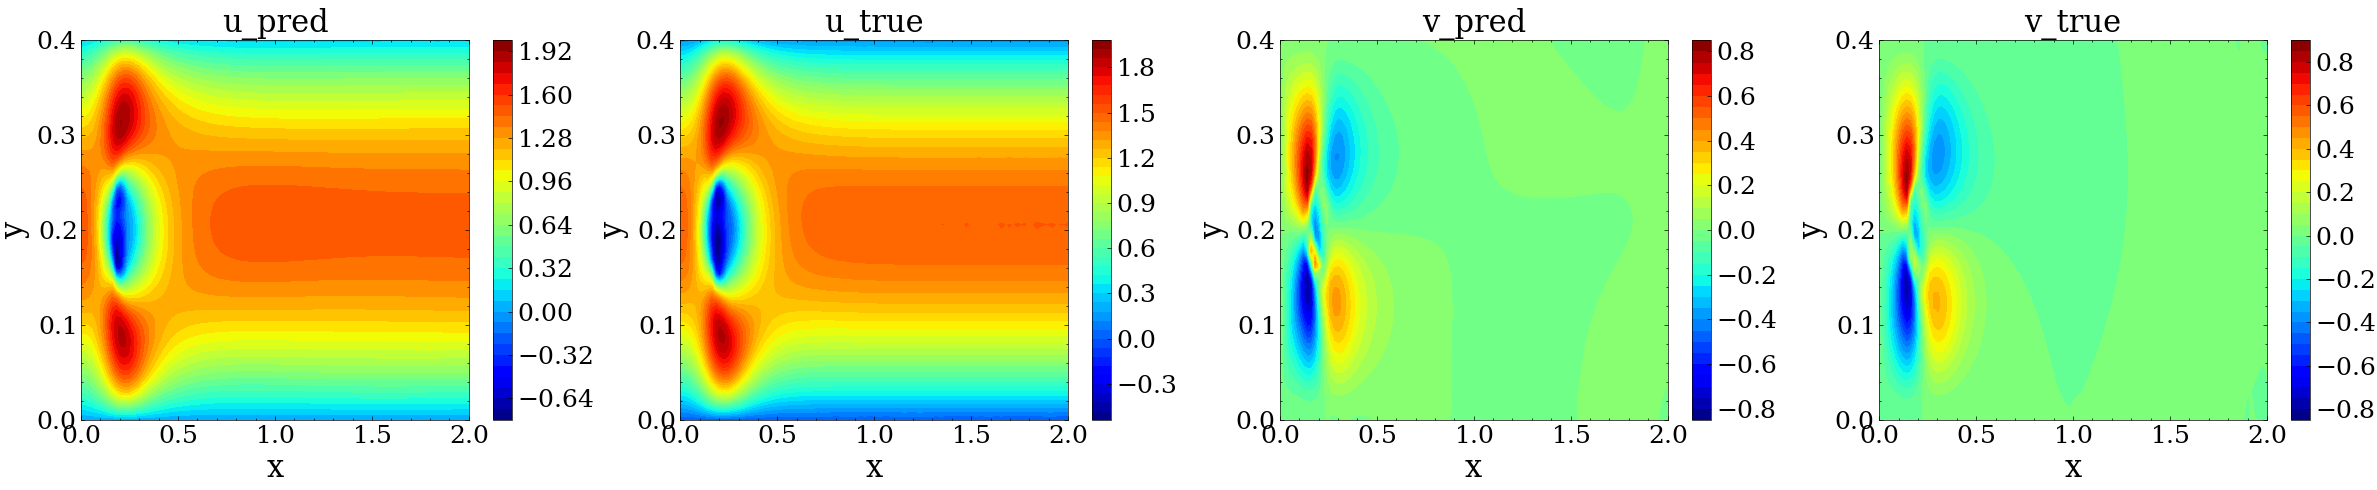

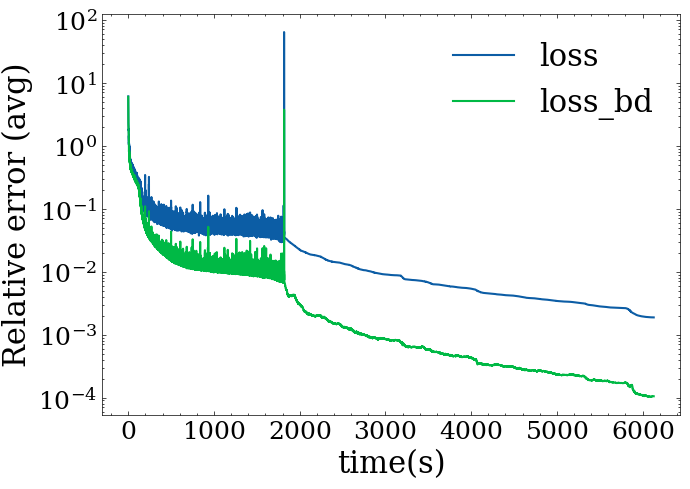

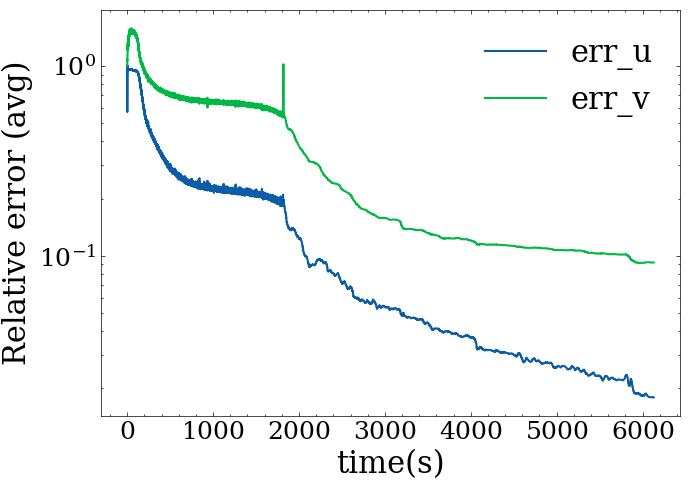

In [3]:
from torch.autograd import Variable
from Utils.PlotFigure import Plot
from Solvers.PINN import PINN
from Utils.Losses import * 
myerror = MyLoss().lp_rel
# #####################################
# # load trained model
# #####################################
solver = PINN.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/', name='model_pinn_final')

###############################
# make prediction
###############################
def get_values(x, solver, model):
    ''' '''
    psi_p = model(x)
    psi, p = psi_p[...,0:1], psi_p[:,1:2]
    #
    dpsi = solver.grad(psi, [x])[0]
    u, v = dpsi[...,1:2], - dpsi[...,0:1]
    #
    s11, s22, s12 = psi_p[...,2:3], psi_p[...,3:4], psi_p[...,4:5]
    
    return u, v, p, s11, s22, s12
#
x_pred = Variable(x_test.to(device), requires_grad=True)
u_pred, v_pred, p_pred, _, _, _= get_values(x_pred, solver, model_trained['psi_p'])
u_pred = u_pred.detach().cpu()
v_pred = v_pred.detach().cpu()
p_pred = p_pred.detach().cpu()
#
print('The l2 error u is:', myerror(u_pred, u_test))
print('The l2 error v is:', myerror(v_pred, v_test))
######################################################
# show the solution
Plot.show_2d_list(x_test, [u_pred, u_test, v_pred, v_test], ['u_pred', 'u_true', 'v_pred', 'v_true'], ub=[2., 0.4])
# show the loss
loss_saved = solver.loadLoss(path=f'saved_models/', name='loss_pinn')
Plot.show_error([loss_saved['time']]*2, 
                [loss_saved['loss'],  loss_saved['loss_bd']],['loss', 'loss_bd'])
# show the error
Plot.show_error([loss_saved['time']]*2, [loss_saved['error'][:,0], loss_saved['error'][:,1]], ['err_u', 'err_v'])